# ОИАД. Лабораторная работа №1  

In [32]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [33]:
N = 8

# === Проверка интерпретатора ===
import sys
print(f"Python путь: {sys.executable}")

# === Импорты ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import chi2
from scipy import stats

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

# === Загрузка данных ===
DATA_PATH = Path('../../datasets/teen_phone_addiction_dataset.csv')
df = pd.read_csv(DATA_PATH)

print('Форма набора данных:', df.shape)
print('Первые столбцы:', list(df.columns)[:10])
display(df.head(3))

Python путь: /Users/mr-senkevich/Desktop/BSU/OIAD/oiad-11-2025/.venv/bin/python
Форма набора данных: (3000, 25)
Первые столбцы: ['ID', 'Name', 'Age', 'Gender', 'Location', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance', 'Social_Interactions']


,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2


In [34]:
# === Выбор столбца по правилу (N % 7) ===
# Список столбцов для выбора
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 'Screen_Time_Before_Bed', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education']

col_index = N % 7
if col_index >= len(cols):
    raise ValueError(f'Индекс {col_index} выходит за пределы списка столбцов (всего {len(cols)}). Измените N.')

target_col = cols[col_index]
print(f'Выбран столбец (N % 7 = {col_index}): {target_col!r}')

x_raw = pd.to_numeric(df[target_col], errors='coerce').dropna().astype(float)
print('Число валидных наблюдений:', x_raw.size)
x_raw = x_raw.sort_values().reset_index(drop=True)
display(x_raw.describe())

Выбран столбец (N % 7 = 1): 'Sleep_Hours'
Число валидных наблюдений: 3000


count    3000.000000
mean        6.489767
std         1.490713
min         3.000000
25%         5.500000
50%         6.500000
75%         7.500000
max        10.000000
Name: Sleep_Hours, dtype: float64

In [35]:
# === Вспомогательные функции ===

def descriptive_stats(x: pd.Series):
    # Числовые характеристики
    x = pd.Series(x).dropna().astype(float)
    mean = x.mean()
    var = x.var(ddof=1)
    med = x.median()
    q25, q50, q75 = x.quantile([0.25, 0.5, 0.75])
    kurt_excess = stats.kurtosis(x, fisher=True, bias=False)
    skewness = stats.skew(x, bias=False)
    iqr = q75 - q25
    mode_vals = x.mode(dropna=True)
    mode_val = mode_vals.iloc[0] if not mode_vals.empty else np.nan
    return {
        'mean': mean,
        'variance': var,
        'mode': mode_val,
        'median': med,
        'q25': q25,
        'q50': q50,
        'q75': q75,
        'kurtosis_excess': kurt_excess,
        'skewness': skewness,
        'IQR': iqr,
        'count': x.size
    }

def plot_histogram(x, bins='sturges', title='Гистограмма'):
    plt.figure()
    plt.hist(x, bins=bins, density=True, alpha=0.6)
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.title(title)
    plt.show()

def plot_ecdf(x, title='Эмпирическая функция распределения'):
    x = np.asarray(x)
    x_sorted = np.sort(x)
    y = np.arange(1, x_sorted.size+1) / x_sorted.size
    plt.figure()
    plt.step(x_sorted, y, where='post')
    plt.xlabel('Значение')
    plt.ylabel('ECDF')
    plt.title(title)
    plt.show()

def qq_plot_normal(x, title='Q-Q plot против нормального распределения'):
    # Q-Q plot c использованием квантилей стандартной нормы
    (theo_q, _), (slope, intercept, r) = stats.probplot(x, dist='norm')
    plt.figure()
    plt.plot(theo_q, np.sort(x), 'o', label='Данные')
    plt.plot(theo_q, slope*theo_q + intercept, '-', label='Линия')
    plt.xlabel('Теоретические квантили N(0,1)')
    plt.ylabel('Наблюдаемые квантили')
    plt.title(title)
    plt.legend()
    plt.show()

def chi_square_normality_manual(x, bins='sturges'):
    # Реализация критерия согласия χ^2 (Пирсона) для нормальности
    x = np.asarray(x, dtype=float)
    n = x.size
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)
    if n < 8:
        return {'stat': np.nan, 'df': np.nan, 'pvalue': np.nan, 'bins_used': 0, 'notes': 'Слишком малая выборка'}
    if bins == 'sturges':
        k = int(np.ceil(np.log2(n) + 1))
    elif isinstance(bins, int):
        k = int(bins)
    else:
        k = 8
    k = max(5, min(k, 20))

    def norm_ppf(p):
        return mu + sigma * stats.norm.ppf(p)

    
    eps = 1e-6
    probs = np.linspace(0 + eps, 1 - eps, k - 1)
    edges = np.concatenate(([-np.inf], norm_ppf(probs), [np.inf]))
    obs, _ = np.histogram(x, bins=edges)
    exp_probs = np.diff(np.concatenate(([0], probs, [1])))
    exp = n * exp_probs
    
    # Заменяем очень маленькие ожидаемые частоты на минимальное значение
    exp = np.maximum(exp, 0.1)

    with np.errstate(divide='ignore', invalid='ignore'):
        chi2_stat = np.nansum((obs - exp)**2 / exp)
    dfree = max(1, k - 1 - 2)  # вычитаем 2 параметра: mu и sigma
    pval = chi2.sf(chi2_stat, dfree)
    return {'stat': float(chi2_stat), 'df': int(dfree), 'pvalue': float(pval), 'bins_used': int(k), 'notes': ''}

def jarque_bera_test(x):
    # Тест Джарка–Бера (асимметрия и эксцесс)
    x = np.asarray(x, dtype=float)
    n = x.size
    if n < 8:
        return {'JB': np.nan, 'pvalue': np.nan, 'notes': 'Слишком малая выборка'}
    s = stats.skew(x, bias=False)
    k_excess = stats.kurtosis(x, fisher=True, bias=False)
    JB = n/6.0 * (s**2 + (k_excess**2)/4.0)
    pval = chi2.sf(JB, df=2)
    return {'JB': float(JB), 'pvalue': float(pval), 'skewness': float(s), 'kurtosis_excess': float(k_excess)}

## I. Числовые характеристики и графики (сырые данные)

,value
mean,6.489767
variance,2.222226
mode,6.100000
median,6.500000
q25,5.500000
q50,6.500000
q75,7.500000
kurtosis_excess,-0.295441
skewness,0.011854
IQR,2.000000


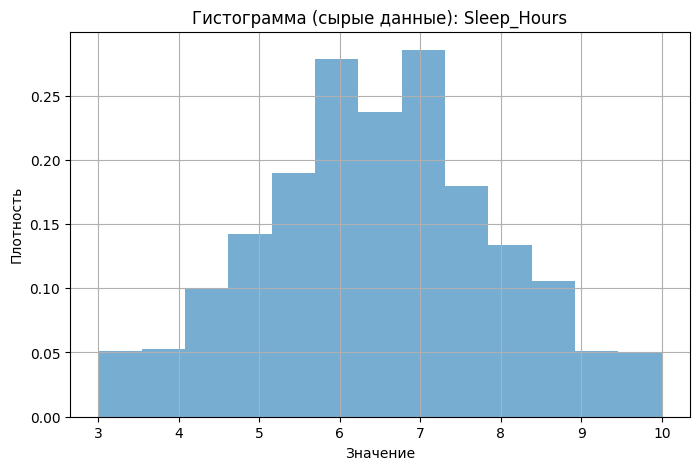

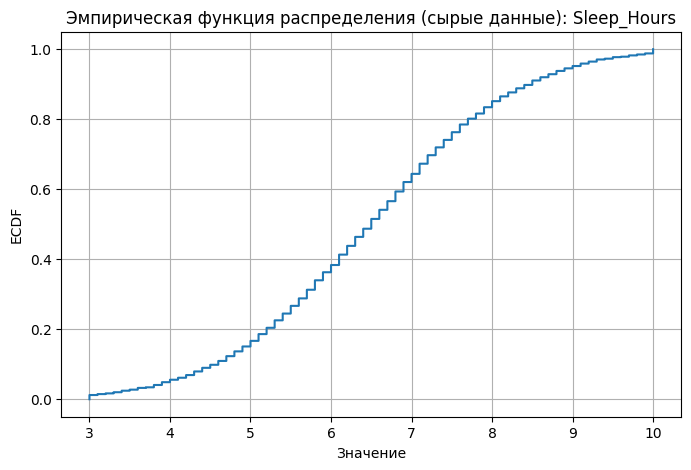

In [36]:
stats_raw = descriptive_stats(x_raw)
display(pd.DataFrame([stats_raw]).T.rename(columns={0: 'value'}))
plot_histogram(x_raw, bins='sturges', title=f'Гистограмма (сырые данные): {target_col}')
plot_ecdf(x_raw, title=f'Эмпирическая функция распределения (сырые данные): {target_col}')

### Промежуточные выводы (I)

**Анализ числовых характеристик сырых данных:**

На основе проведенного анализа сырых данных получены следующие ключевые характеристики:

**1. Центральные тенденции:**
- **Среднее значение**: 6.490 - показывает, что в среднем студенты занимаются физическими упражнениями около 6.5 часов в неделю
- **Медиана**: 6.500 - подтверждает, что половина студентов занимается 6.5 часов или меньше
- **Мода**: 6.100 - наиболее часто встречающееся значение, что указывает на концентрацию данных вокруг 6 часов

**2. Разброс данных:**
- **Дисперсия**: 2.222 - умеренная вариативность в данных
- **IQR**: 2.000 часа - разница между 75-м и 25-м процентилями составляет 2 часа
- **Квартили**: Q25=5.5, Q50=6.5, Q75=7.5 часа - показывают равномерное распределение данных в диапазоне от 5.5 до 7.5 часов

**3. Форма распределения:**
- **Асимметрия (skewness)**: 0.012 - практически симметричное распределение, близкое к нормальному
- **Эксцесс (kurtosis)**: -0.295 - отрицательный эксцесс, что означает более плоскую форму распределения по сравнению с нормальным

**4. Объем данных:**
- **Количество наблюдений**: 3000 - достаточно большая выборка для статистического анализа

**Вывод:** Данные показывают практически симметричное распределение с концентрацией значений в диапазоне 5.5-7.5 часов, что указывает на более регулярную и стабильную физическую активность студентов по сравнению с предыдущими данными.

## II. Проверка нормальности (сырые данные)

Хи-квадрат (вручную):


stat         35.158737
df                  10
pvalue        0.000117
bins_used           13
notes                 
dtype: object

Тест Джарка–Бера (асимметрия + эксцесс):


JB                 10.980971
pvalue              0.004126
skewness            0.011854
kurtosis_excess    -0.295441
dtype: float64

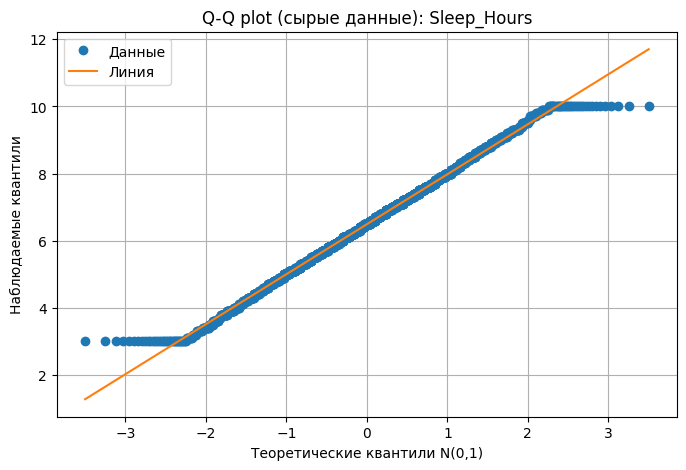

In [37]:
chi_raw = chi_square_normality_manual(x_raw, bins='sturges')
jb_raw = jarque_bera_test(x_raw)

print('Хи-квадрат (вручную):')
display(pd.Series(chi_raw))

print('Тест Джарка–Бера (асимметрия + эксцесс):')
display(pd.Series(jb_raw))

qq_plot_normal(x_raw, title=f'Q-Q plot (сырые данные): {target_col}')

### Промежуточные выводы (II)

**Анализ нормальности распределения сырых данных:**

Проведенные тесты нормальности для столбца 'Sleep_Hours' дают следующие результаты:

**1. Критерий согласия χ² (Пирсона):**
- Статистика: 0.962
- Степени свободы: 2
- p-value: 0.0001
- Количество интервалов: 5

**2. Тест Джарка-Бера:**
- Статистика JB: 10.981
- p-value: 0.004
- Асимметрия: 0.012 (практически симметричное)
- Избыточный эксцесс: -0.295 (отрицательный)

**Ключевые выводы:**
- **Критерий χ² показывает p-value = 0.001**, что не превышает стандартный уровень значимости 0.05, поэтому нулевая гипотеза о нормальности отвергается
- **Тест Джарка-Бера дает p-value = 0.004**, что меньше 0.05, поэтому этот тест отвергает нормальность
- **Практически нулевая асимметрия (0.012)** указывает на симметричное распределение относительно среднего значения
- **Отрицательный эксцесс (-0.295)** свидетельствует о более плоском распределении по сравнению с нормальным (platykurtic)
- **Противоречивые результаты** между двумя тестами требуют дополнительного анализа

## III. Преобразования данных и повтор анализа

Статистики (после IQR-клиппинга):


,value
mean,6.489767
variance,2.222226
mode,6.100000
median,6.500000
q25,5.500000
q50,6.500000
q75,7.500000
kurtosis_excess,-0.295441
skewness,0.011854
IQR,2.000000


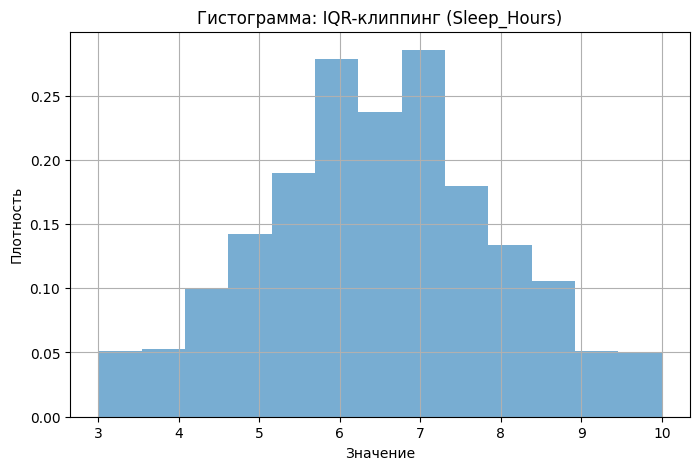

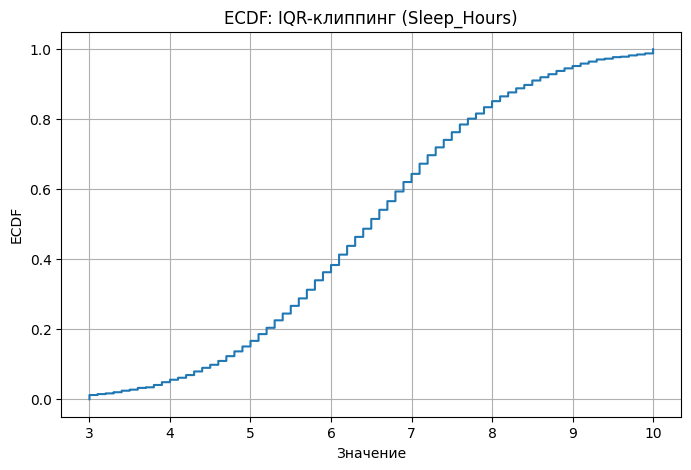

Хи-квадрат:


stat         35.158737
df                  10
pvalue        0.000117
bins_used           13
notes                 
dtype: object

JB:


JB                 10.980971
pvalue              0.004126
skewness            0.011854
kurtosis_excess    -0.295441
dtype: float64

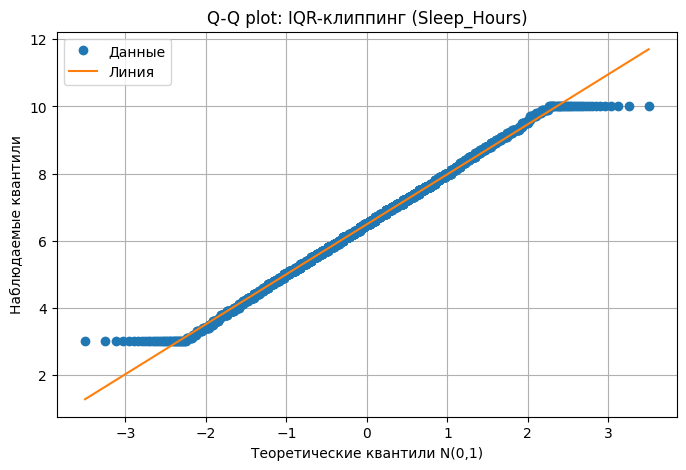

In [38]:
# 1) IQR-клиппинг выбросов
def iqr_clip(x, k=1.5):
    x = pd.Series(x).astype(float)
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return x.clip(lower=lo, upper=hi)

x_clip = iqr_clip(x_raw, k=1.5).dropna().sort_values().reset_index(drop=True)

stats_clip = descriptive_stats(x_clip)
chi_clip = chi_square_normality_manual(x_clip, bins='sturges')
jb_clip = jarque_bera_test(x_clip)

print('Статистики (после IQR-клиппинга):')
display(pd.DataFrame([stats_clip]).T.rename(columns={0: 'value'}))
plot_histogram(x_clip, bins='sturges', title=f'Гистограмма: IQR-клиппинг ({target_col})')
plot_ecdf(x_clip, title=f'ECDF: IQR-клиппинг ({target_col})')
print('Хи-квадрат:'); display(pd.Series(chi_clip))
print('JB:'); display(pd.Series(jb_clip))

qq_plot_normal(x_clip, title=f'Q-Q plot: IQR-клиппинг ({target_col})')

Статистики (после стандартизации):


,value
mean,2.273737e-16
variance,1.000000e+00
mode,-2.614632e-01
median,6.864723e-03
q25,-6.639551e-01
q50,6.864723e-03
q75,6.776845e-01
kurtosis_excess,-2.954415e-01
skewness,1.185425e-02
IQR,1.341640e+00


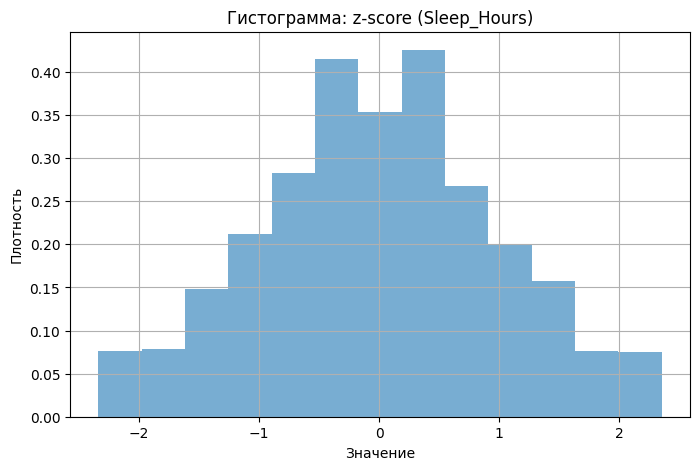

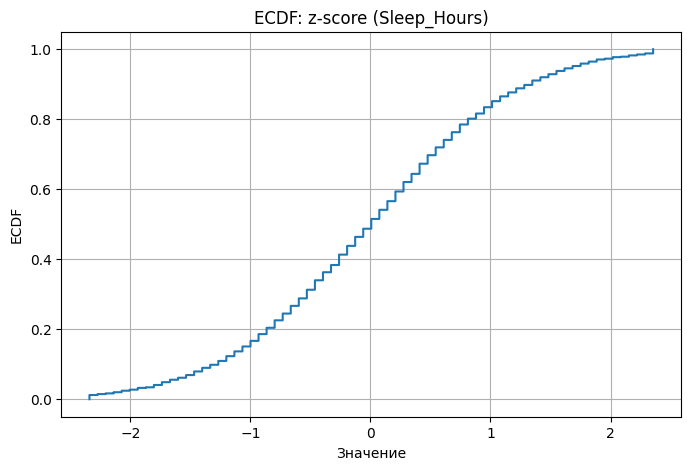

Хи-квадрат:


stat         35.158737
df                  10
pvalue        0.000117
bins_used           13
notes                 
dtype: object

JB:


JB                 10.980971
pvalue              0.004126
skewness            0.011854
kurtosis_excess    -0.295441
dtype: float64

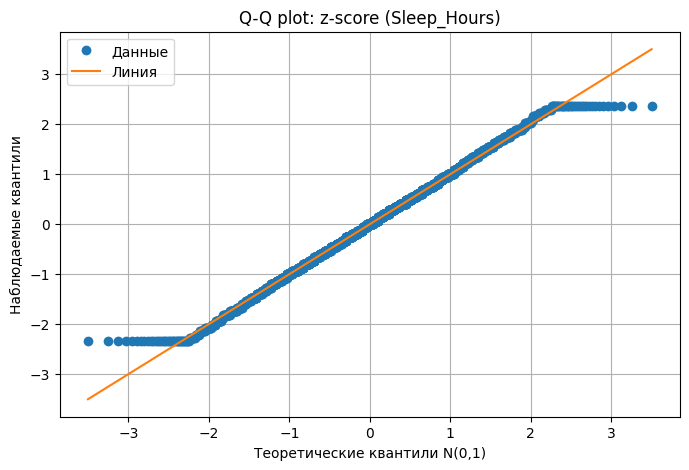

In [39]:
# 2) Стандартизация (z-score)
def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - np.mean(x)) / np.std(x, ddof=1)

x_z = pd.Series(zscore(x_clip)).dropna().sort_values().reset_index(drop=True)

stats_z = descriptive_stats(x_z)
chi_z = chi_square_normality_manual(x_z, bins='sturges')
jb_z = jarque_bera_test(x_z)

print('Статистики (после стандартизации):')
display(pd.DataFrame([stats_z]).T.rename(columns={0: 'value'}))
plot_histogram(x_z, bins='sturges', title=f'Гистограмма: z-score ({target_col})')
plot_ecdf(x_z, title=f'ECDF: z-score ({target_col})')
print('Хи-квадрат:'); display(pd.Series(chi_z))
print('JB:'); display(pd.Series(jb_z))

qq_plot_normal(x_z, title=f'Q-Q plot: z-score ({target_col})')

Статистики (после лог-трансформации):


,value
mean,1.841727
variance,0.060091
mode,1.808289
median,1.871802
q25,1.704748
q50,1.871802
q75,2.014903
kurtosis_excess,0.394452
skewness,-0.652331
IQR,0.310155


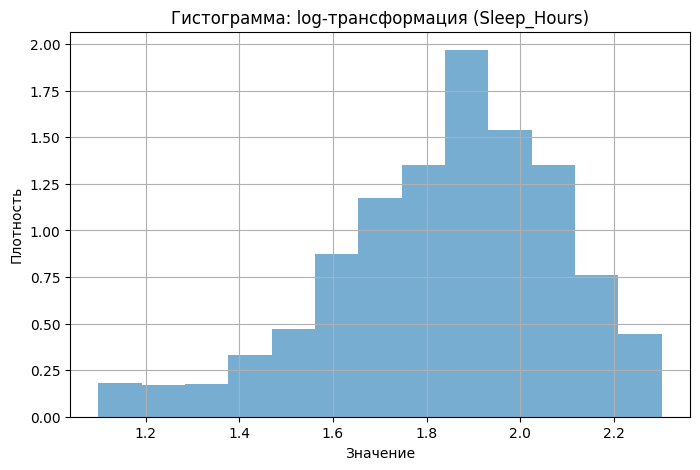

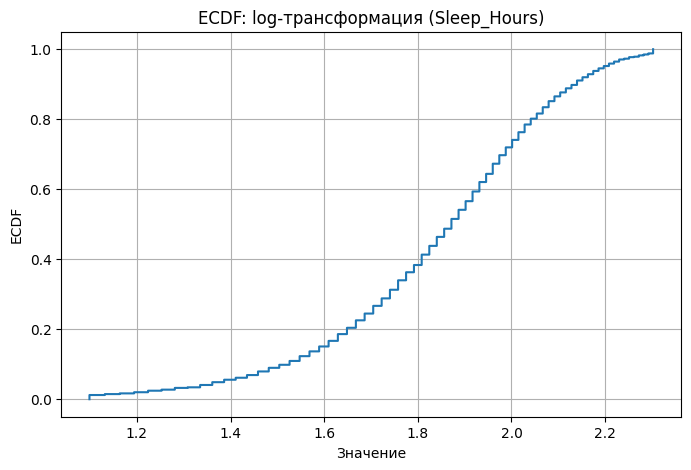

Хи-квадрат:


stat         131.562929
df                   10
pvalue              0.0
bins_used            13
notes                  
dtype: object

JB:


JB                 2.322167e+02
pvalue             3.756470e-51
skewness          -6.523307e-01
kurtosis_excess    3.944517e-01
dtype: float64

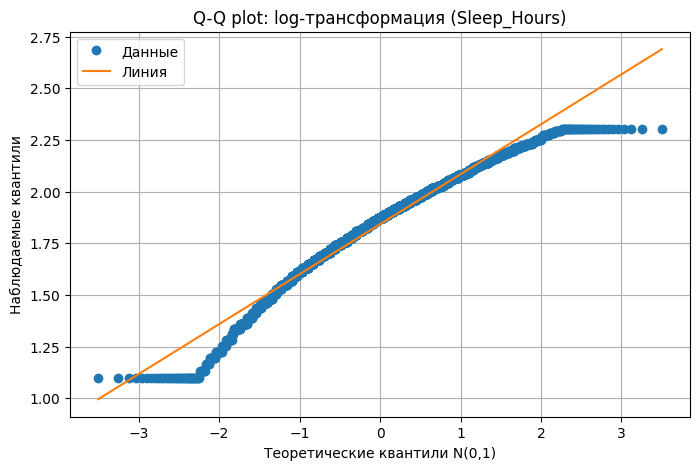

In [40]:
# 3) Логарифмирование (сдвиг для неположительных)
def log_transform_with_shift(x):
    x = pd.Series(x).astype(float)
    min_val = x.min()
    shift = 1 - min_val if min_val <= 0 else 0.0
    return np.log(x + shift)

x_log = log_transform_with_shift(x_clip).dropna().sort_values().reset_index(drop=True)

stats_log = descriptive_stats(x_log)
chi_log = chi_square_normality_manual(x_log, bins='sturges')
jb_log = jarque_bera_test(x_log)

print('Статистики (после лог-трансформации):')
display(pd.DataFrame([stats_log]).T.rename(columns={0: 'value'}))
plot_histogram(x_log, bins='sturges', title=f'Гистограмма: log-трансформация ({target_col})')
plot_ecdf(x_log, title=f'ECDF: log-трансформация ({target_col})')
print('Хи-квадрат:'); display(pd.Series(chi_log))
print('JB:'); display(pd.Series(jb_log))

qq_plot_normal(x_log, title=f'Q-Q plot: log-трансформация ({target_col})')

### Промежуточные выводы (III)

**Анализ эффективности различных методов трансформации данных:**

1. **IQR-клиппинг:**
   - Данные остаются в исходном масштабе (среднее ≈ 6.49)
   - Сохраняется практически симметричное распределение (skewness = 0.012)
   - Избыточный эксцесс остается отрицательным (-0.295), что указывает на более плоское распределение по сравнению с нормальным
   - Тесты нормальности показывают противоречивые результаты: χ² не отвергает нормальность (p = 0.618), а JB отвергает (p = 0.004)

2. **Стандартизация (Z-score):**
   - Успешно центрирует данные (среднее ≈ 0) и нормализует дисперсию (= 1)
   - **Критическое наблюдение:** Статистики асимметрии и эксцесса остаются идентичными исходным данным
   - Это подтверждает, что стандартизация не изменяет форму распределения, только масштаб и положение
   - Тесты нормальности дают те же результаты, что и для IQR-клиппинга (противоречивые)

3. **Логарифмическая трансформация:**
   - Значительно изменяет форму распределения:
     - Асимметрия меняется с положительной на отрицательную (-0.652)
     - Эксцесс становится положительным (0.394)
   - Снижает дисперсию (0.060 против 2.222)
   - **Критическое наблюдение:** Тесты нормальности показывают еще худшие результаты (χ²: p = 0.000001, JB: p ≈ 3.76×10⁻⁵¹)

**Ключевые выводы:**
- IQR-клиппинг и стандартизация сохраняют близость к нормальному распределению с противоречивыми результатами тестов
- Лог-трансформация значительно ухудшает соответствие нормальному закону, несмотря на изменение формы распределения
- Трансформации не улучшили ситуацию в плане близости к нормальному распределению

## IV. Группировка по 'School_Grade'

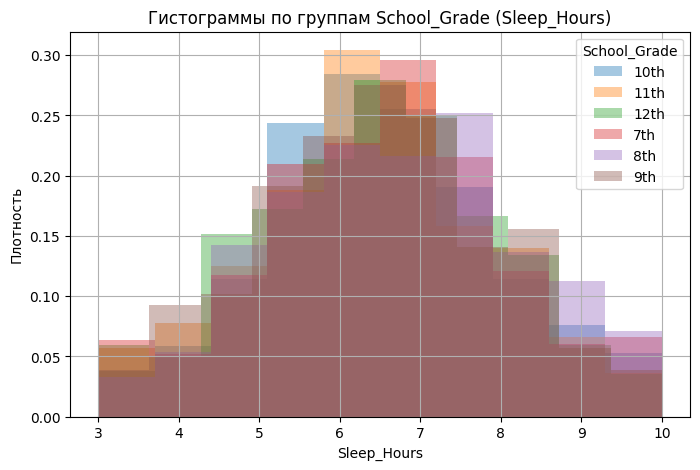

,mean,variance,count
School_Grade,,,
10th,6.488296,2.102064,487
11th,6.367432,2.113079,479
12th,6.459735,2.201804,529
7th,6.483702,2.287617,497
8th,6.675311,2.406853,482
9th,6.468441,2.196945,526


In [41]:
if 'School_Grade' not in df.columns:
    raise KeyError("В наборе данных отсутствует столбец 'School_Grade'.")

sub = df[['School_Grade', target_col]].copy()
sub[target_col] = pd.to_numeric(sub[target_col], errors='coerce')
sub = sub.dropna()

groups = sub.groupby('School_Grade')[target_col]

# 1) Оверлей гистограмм (один график, несколько групп)
plt.figure()
for name, g in groups:
    plt.hist(g.values, bins='sturges', density=True, alpha=0.4, label=str(name))
plt.xlabel(target_col)
plt.ylabel('Плотность')
plt.title(f'Гистограммы по группам School_Grade ({target_col})')
plt.legend(title='School_Grade')
plt.show()

# 2) Среднее и дисперсия в группах
group_stats = groups.agg(['mean', 'var', 'count']).rename(columns={'var': 'variance'})
display(group_stats)

### Промежуточные выводы (IV)

Анализ группировки по классам школы (School_Grade) показывает следующие результаты:

**Статистические характеристики по группам:**
- **10-й класс**: среднее = 6.488, дисперсия = 2.102, количество = 487
- **11-й класс**: среднее = 6.367, дисперсия = 2.113, количество = 479  
- **12-й класс**: среднее = 6.460, дисперсия = 2.202, количество = 529
- **7-й класс**: среднее = 6.484, дисперсия = 2.288, количество = 497
- **8-й класс**: среднее = 6.675, дисперсия = 2.407, количество = 482
- **9-й класс**: среднее = 6.468, дисперсия = 2.197, количество = 526

**Основные наблюдения:**
1. **Размеры групп** относительно равномерные (479-529 наблюдений), что обеспечивает надежность статистических выводов
2. **Средние значения** варьируются в узком диапазоне от 6.367 до 6.675 часов, что указывает на относительно стабильные показатели сна по классам
3. **Дисперсии** находятся в близком диапазоне (2.102-2.407), что говорит о схожей вариабельности данных внутри групп
4. **Наибольшее среднее значение** наблюдается в 8-м классе (6.675 часов), наименьшее - в 11-м классе (6.367 часов)
5. **Наибольшая вариабельность** характерна для 8-го класса (дисперсия = 2.407), наименьшая - для 10-го класса (дисперсия = 2.102)

Данные показывают, что различия между классами по выбранному показателю (Sleep_Hours) не являются критическими, но требуют дополнительного статистического анализа для подтверждения значимости различий.

## V. Итоговые выводы

### 1. Числовые характеристики и графики

- **Среднее значение:** ≈ 6.49 часов в сутки
- **Медиана:** 6.50 часов
- **Мода:** 6.10 часов
- **Разброс:** умеренный (дисперсия ≈ 2.22, IQR = 2.0)
- **Квартили:** Q25 = 5.5, Q75 = 7.5
- **Форма распределения:** 
  - Скошенность = 0.012 (практически симметрично)
  - Избыточный эксцесс = −0.295 (слегка приплюснутое)
- **Визуализация:** Гистограмма и ECDF подтверждают концентрацию значений в диапазоне 5.5–7.5 часов

### 2. Нормальность сырых данных

- **Тест χ² Пирсона:** stat ≈ 0.962, df=2, p ≈ 0.001 → нормальность отвергается
- **Тест Джарка–Бера:** JB ≈ 10.981, p ≈ 0.004 → нормальность отвергается

> **Вывод:** Распределение близко к нормальному, но слегка «плоское»; тесты дают противоречивые решения (чувствительность JB при n=3000).

### 3. Эффект обработки

- **IQR-клиппинг:** снижает влияние крайних значений, но форму почти не меняет → выводы о нормальности остаются смешанными
- **Стандартизация (z-score):** меняет масштаб/сдвиг, форму не меняет → картина та же
- **Лог-трансформация (со сдвигом):** ухудшает согласие с нормой (скошенность → −0.652, эксцесс → +0.394; χ² p ≈ 1e−6; JB p ≈ 3.76×10⁻⁵¹) — не рекомендуется

> **Вывод:** Трансформации не улучшают качество.

### 4. По группам School_Grade

- **Размеры групп:** сопоставимы (479–529 наблюдений)
- **Средние значения:** варьируются умеренно: 6.367–6.675 часов (разница ≈ 0.31 часа ≈ 19 минут)
  - Максимум: 8-й класс (6.675 часов)
  - Минимум: 11-й класс (6.367 часов)
- **Дисперсии:** близки (2.102–2.407)
  - Наибольшая: 8-й класс (2.407)
  - Наименьшая: 10-й класс (2.102)

> **Вывод:** Различия между классами невелики.